<a href="https://colab.research.google.com/github/EnterTheBeginning/SmartHomeEnergyForecasting/blob/master/Feature_engineering_for_NYISO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Working 1:

Tsfresh. PCA for reduction of dimensions profit.   
optional: Add weekdays,weekends features, Hours features Too*?* 1/24


In [14]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout, GRU, Bidirectional,Activation,Flatten
import math
from sklearn.metrics import mean_squared_error
from keras.optimizers import SGD

import statsmodels.api as sm
import seaborn as sns


from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#import the dataset
df = pd.read_excel('/content/gdrive/My Drive/Colab Notebooks/1. DataAnalytics/~Code/Data/loadprice.xlsx',parse_dates=['time'])


In [16]:
df.head()

,time,price,Load,priceforecast,loadforecast,precipIntensity,precipProbability,temperature,humidity,windSpeed,windBearing,pressure,dewPoint,cloudCover
0,2016-01-01 00:00:00,294.79,1158.8,30.19,1171,0.0,0.0,36.52,0.61,9.11,281.0,1016.88,24.27,NaN
1,2016-01-01 01:00:00,18.78,1104.1,25.35,1094,0.0,0.0,36.32,0.60,8.93,285.0,1016.23,23.71,0.75
2,2016-01-01 02:00:00,33.90,1062.4,21.12,1025,0.0,0.0,35.77,0.61,7.90,282.0,1015.99,23.57,NaN
3,2016-01-01 03:00:00,15.52,1040.8,21.07,1009,0.0,0.0,35.62,0.63,5.35,264.0,1016.03,24.11,NaN
4,2016-01-01 04:00:00,1.95,1035.5,22.44,987,0.0,0.0,35.97,0.62,6.80,267.0,1015.89,24.13,NaN


Text(0.5, 1.0, 'Correlation between different fearures')

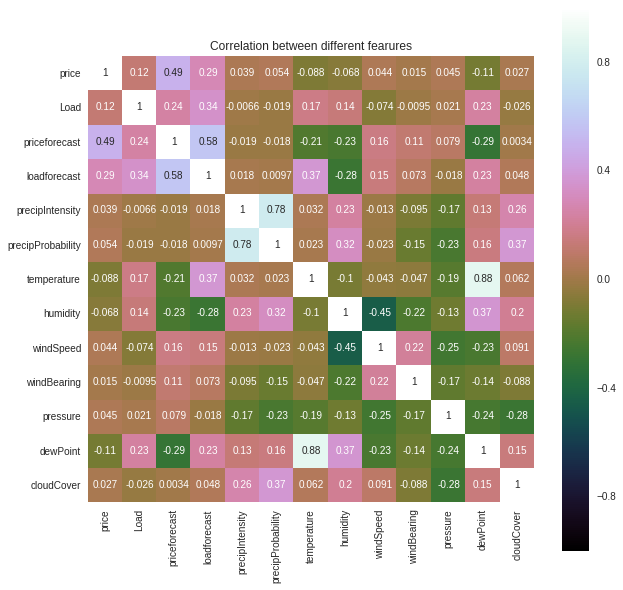

In [17]:
correlation = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

plt.title('Correlation between different fearures')


In [0]:
df['time'] = pd.to_datetime(df['time'],unit='ms')
df['time'] = df['time'].astype('datetime64[ns]')
df = df.set_index('time')


In [19]:
hour = df.resample('h').mean()
df =df.fillna(df.mean())
hour = hour.fillna(hour.mean())
hour.isnull().sum()


price                0
Load                 0
priceforecast        0
loadforecast         0
precipIntensity      0
precipProbability    0
temperature          0
humidity             0
windSpeed            0
windBearing          0
pressure             0
dewPoint             0
cloudCover           0
dtype: int64

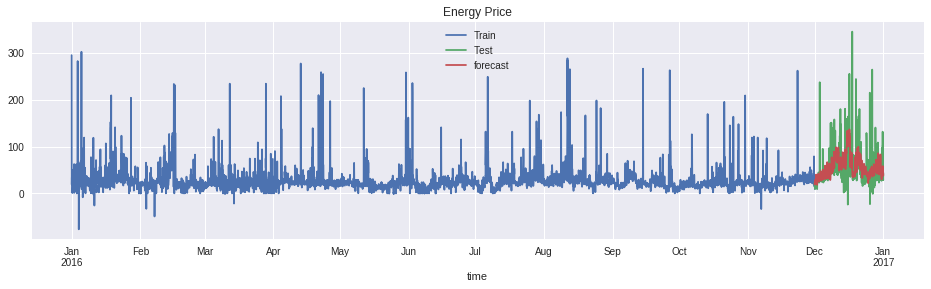

In [20]:
hour['price'][:'2016-12-01'].plot(figsize=(16,4),legend = True)
hour['price']['2016-12-01':].plot(figsize=(16,4),legend = True)
hour['priceforecast']['2016-12-01':].plot(figsize=(16,4),legend = True)
plt.legend(['Train','Test','forecast'])
plt.title('Energy Price')
plt.show()

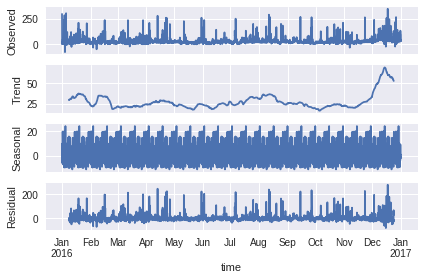

In [21]:
decomposition = sm.tsa.seasonal_decompose(hour['price'], freq=360)

fig = decomposition.plot()
plt.show()


# LSTM Model

In [27]:
training_set = hour['2016-01-01':'2016-11-11'].iloc[:,0:6].values
test_set = hour['2016-11-11':'2016-11-13'].iloc[:,0:6].values
y_training_set  = hour['2016-01-01':'2016-11-11'].iloc[:,0:6].values
y_test_set= hour['2016-11-11':'2016-11-13'].iloc[:,0:1].values
#Scaling
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
test_set_scaled= sc.fit_transform(test_set)
y_train_scaled = sc.fit_transform(y_training_set)
y_test_scaled = sc.fit_transform(y_test_set)
X_train =[]
y_train = []
for i in range (24,training_set.shape[0]):
  X_train.append(training_set_scaled[i-24:i,0:6])
  y_train.append(y_train_scaled[i,0])
X_train , y_train = np.array(X_train),np.array(y_train)
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],X_train.shape[2]))
y_train =y_train.reshape(y_train.shape[0],1)
#X test Defining
X_test = []
y_test = []
for i in range (24,test_set.shape[0]):
  X_test.append(test_set_scaled[i-24:i,0:6])
  y_test.append(y_test_scaled[i,0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],X_test.shape[2]))
y_test =y_test.reshape(y_test.shape[0],1)
print(X_test.shape)

(7560, 24, 6)
(48, 24, 6)


In [0]:
model = Sequential()
layers = [24, 50,100, 1]


In [0]:
#model 1:
model.add(LSTM(layers[1],input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(layers[2],return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(layers[3]))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="rmsprop")

In [30]:
model.fit(X_train, y_train,batch_size=256, nb_epoch=1)

Epoch 1/1
7560/7560 [==============================] - 7s 899us/step - loss: 0.0084


In [31]:
prediction = model.predict(X_test)
score = model.evaluate(X_test,y_test,verbose =0)
print('Test Loss:', score)

Test Loss: 0.03376706379155318


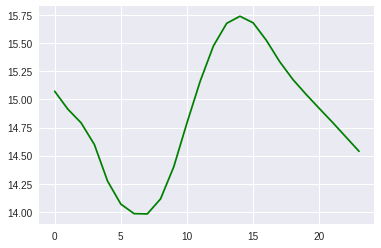

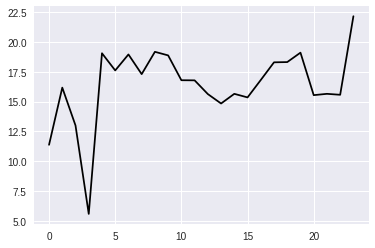

In [32]:
prediction = model.predict(X_test)
prediction = sc.inverse_transform(prediction)
y_test = sc.inverse_transform(y_test)
plt.plot(prediction[:24], color='green',label='Predicted')
plt.show()
plt.plot(y_test[:24], color='black',label='Real')
plt.show()

In [33]:
!pip install tsfresh

In [0]:
X_train =[]
y_train = []
for i in range (24,training_set.shape[0]):
  X_train.append(training_set_scaled[i-24:i,0])
  y_train.append(training_set_scaled[i,0])

In [0]:
hourdata = pd.read_excel('/content/gdrive/My Drive/Colab Notebooks/1. DataAnalytics/~Code/Data/hourprice.xlsx',parse_dates=['time'])

In [0]:
arg1 = hourdata.set_index('time1')
y = pd.Series(arg1['price'])
X=hourdata.set_index('time1')

In [37]:
from tsfresh import extract_relevant_features,extract_features
ts = extract_features(hourdata[hourdata.shape[0]-1000:hourdata.shape[0]], column_id='time1', column_sort='time')
# error ts = extract_relevant_features(hourdata[:10],y[:10],column_id='time1', column_sort='time')

Feature Extraction: 100%|██████████| 5/5 [00:46<00:00,  9.35s/it]


In [0]:
ts.to_excel('features.xlsx')

In [39]:
X.isnull().sum()


time     0
price    0
dtype: int64

# PCA


Covariance matrix:


In [40]:
mean_vec = np.mean(training_set_scaled, axis=0)
cov_mat = (training_set_scaled - mean_vec).T.dot((training_set_scaled - mean_vec)) / (training_set_scaled.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)


Covariance matrix 
[[ 3.32017181e-03  1.41192962e-03  2.74587009e-03  3.12404685e-03
   1.36121754e-04  6.95105675e-04]
 [ 1.41192962e-03  3.25534557e-02  6.31523703e-03  1.20689693e-02
   1.53410756e-05 -4.90097344e-04]
 [ 2.74587009e-03  6.31523703e-03  1.39446524e-02  1.47931207e-02
  -1.27415545e-04 -5.13218094e-04]
 [ 3.12404685e-03  1.20689693e-02  1.47931207e-02  3.28854017e-02
   2.09895854e-04  4.00634526e-04]
 [ 1.36121754e-04  1.53410756e-05 -1.27415545e-04  2.09895854e-04
   2.55086172e-03  7.21906224e-03]
 [ 6.95105675e-04 -4.90097344e-04 -5.13218094e-04  4.00634526e-04
   7.21906224e-03  3.51188814e-02]]


In [41]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)


Eigenvectors 
[[ 0.08505204  0.02264293  0.06342325  0.2718596   0.95619428 -0.00397342]
 [ 0.58840685 -0.02399952 -0.80807625  0.01416682 -0.00218642  0.00294742]
 [ 0.38466749 -0.00639811  0.29549668  0.82544274 -0.28839867 -0.01192417]
 [ 0.70604818  0.03189051  0.50441984 -0.49403841  0.0434834   0.00865073]
 [ 0.00122595  0.20693729 -0.00901202 -0.01167436 -0.00515741 -0.97822868]
 [-0.00830195  0.97725654 -0.03393193  0.01804702 -0.02442365  0.20694722]]

Eigenvalues 
[0.05137498 0.03669212 0.02257915 0.00609409 0.00261234 0.00102074]


Text(0, 0.5, 'Cumulative explained variance')

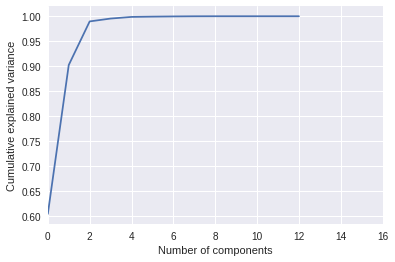

In [42]:
from sklearn.decomposition import PCA
pca = PCA().fit(df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,16,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')


95% varince by 2nd component

In [43]:
sklearn_pca = PCA(n_components=4)
Y_sklearn = sklearn_pca.fit_transform(df)
print(Y_sklearn)
Y_sklearn.shape


[[-286.73073495   51.00313241  -83.25362103  164.36601767]
 [-385.18152635   28.09132736  -90.28566334    6.34859207]
 [-462.68890883    6.94625408  -89.63137014   13.97085317]
 ...
 [  58.92729047   61.8571162     4.22063141    7.24298772]
 [  23.61007123   24.78108722    1.66380749    2.77752441]
 [ -33.69057199  -35.51413955   -2.62437151   13.24994795]]


(8785, 4)

Thus Principal Component Analysis is used to remove the redundant features from the datasets without losing much information.These features are low dimensional in nature.The first component has the highest variance followed by second, third and so on.PCA works best on data set having 3 or higher dimensions. Because, with higher dimensions, it becomes increasingly difficult to make interpretations from the resultant cloud of data.

